In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [51]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [53]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

print("Class order used in training:", dataset.class_names)


Found 2152 files belonging to 3 classes.
Class order used in training: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [54]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [55]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 256, 256, 3)
[0 1 1 0 1 0 1 0 1 1 1 1 0 1 2 1]


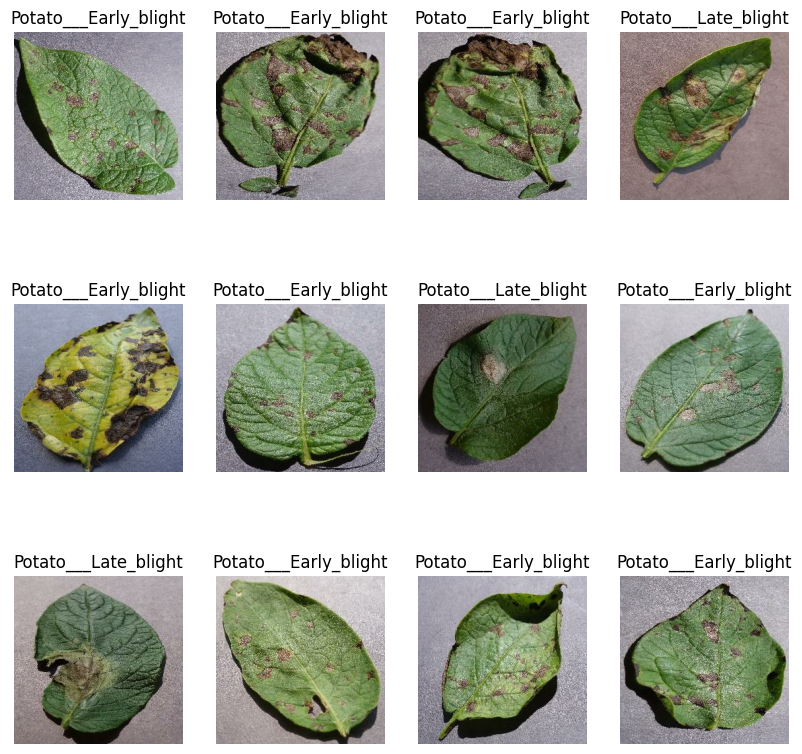

In [6]:

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

68

In [56]:
train_size = 0.8
len(dataset)*train_size

108.0

In [57]:
train_ds = dataset.take(54)
len(train_ds)

54

In [60]:

test_ds = dataset.skip(54)
len(test_ds)


81

In [11]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)


6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:

len(train_ds)

54

In [17]:
len(val_ds)



6

In [49]:
len(test_ds)


AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

In [19]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255),
])
#new verion of tesnerflow

In [21]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])


In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [23]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)   # no batch size
n_classes = 3

model = models.Sequential([
    tf.keras.Input(shape=input_shape),   # 👈 define input layer properly
    
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])


In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)      

In [25]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [45]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=100,
)

Epoch 1/100
54/54 [==============================] - 85s 2s/step - loss: 0.0398 - accuracy: 0.9821 - val_loss: 0.0305 - val_accuracy: 0.9844
Epoch 2/100
54/54 [==============================] - 76s 1s/step - loss: 0.0416 - accuracy: 0.9855 - val_loss: 0.0831 - val_accuracy: 0.9688
Epoch 3/100
54/54 [==============================] - 74s 1s/step - loss: 0.0443 - accuracy: 0.9867 - val_loss: 0.0714 - val_accuracy: 0.9896
Epoch 4/100
54/54 [==============================] - 75s 1s/step - loss: 0.0533 - accuracy: 0.9786 - val_loss: 0.1084 - val_accuracy: 0.9583
Epoch 5/100
54/54 [==============================] - 75s 1s/step - loss: 0.0296 - accuracy: 0.9907 - val_loss: 0.0698 - val_accuracy: 0.9844
Epoch 6/100
54/54 [==============================] - 74s 1s/step - loss: 0.0177 - accuracy: 0.9936 - val_loss: 0.0760 - val_accuracy: 0.9740
Epoch 7/100
54/54 [==============================] - 74s 1s/step - loss: 0.0667 - accuracy: 0.9797 - val_loss: 0.0818 - val_accuracy: 0.9792
Epoch 8/100
5

In [27]:

history

In [28]:

history.params

{'verbose': 1, 'epochs': 12, 'steps': 54}

In [29]:

history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
type(history.history['loss'])

list

In [31]:

len(history.history['loss'])

12

In [32]:
history.history['loss'][:5]

[1.7540451288223267,
 0.5322998762130737,
 0.2679664194583893,
 0.21445292234420776,
 0.20016714930534363]

In [33]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

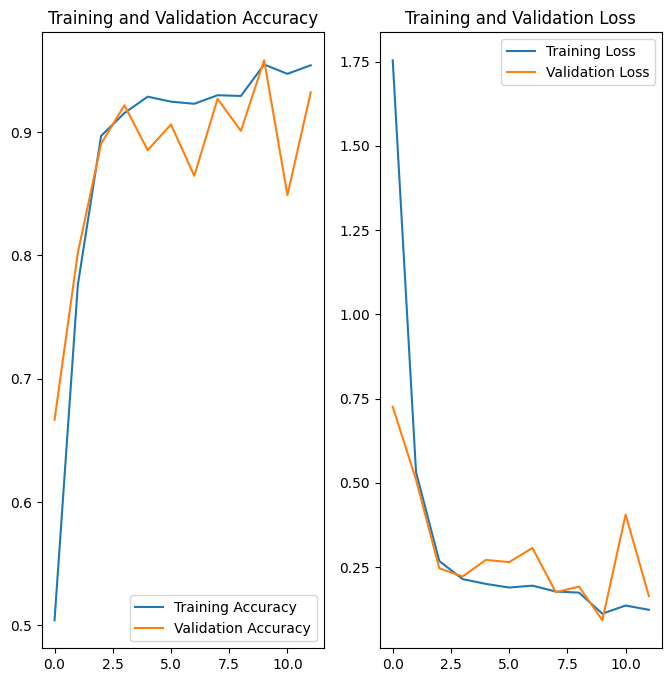

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))   # instead of range(EPOCHS)

plt.figure(figsize=(8, 8))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 890ms/step
predicted label: Potato___healthy


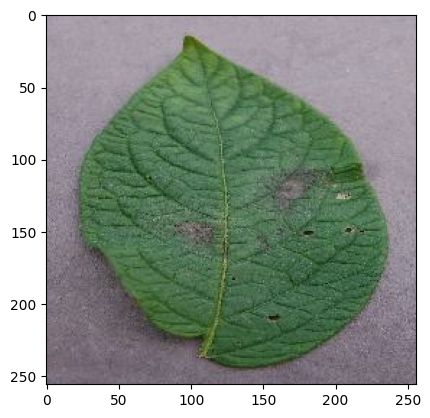

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 80ms/step


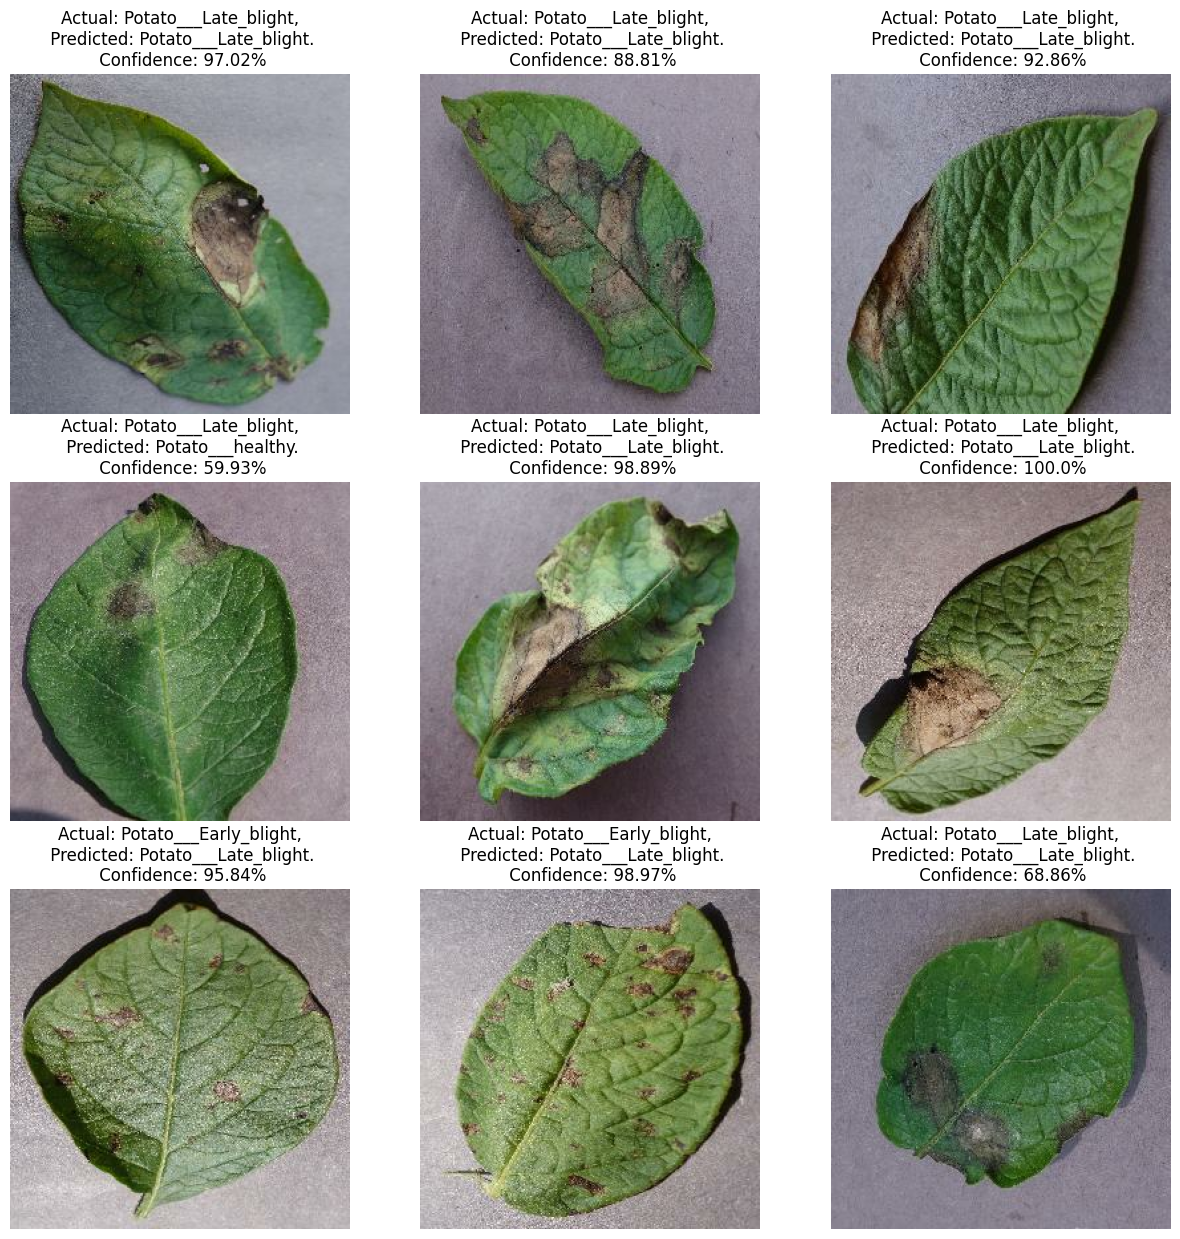

In [37]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [46]:
import os

# Path to models folder
models_path = r"C:\Users\ADMIN\Desktop\potato diseases\saved_models"
os.makedirs(models_path, exist_ok=True)

# Find next version number
existing = [int(f) for f in os.listdir(models_path) if f.isdigit()]
model_version = max(existing + [0]) + 1

# Save in TensorFlow SavedModel format (folder)
save_path = os.path.join(models_path, str(model_version))
model.save(save_path)   # <-- use save() here

print(f"✅ Model saved at: {save_path}")


INFO:tensorflow:Assets written to: C:\Users\ADMIN\Desktop\potato diseases\saved_models\1\assets


INFO:tensorflow:Assets written to: C:\Users\ADMIN\Desktop\potato diseases\saved_models\1\assets


✅ Model saved at: C:\Users\ADMIN\Desktop\potato diseases\saved_models\1


In [39]:

model.save("../potatoes.h5")